In [1]:
import os
import re
import json
import faiss
import numpy as np
import huggingface_hub
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm import tqdm
from openai import OpenAI
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore

from matplotlib import font_manager, rc
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

from dotenv import load_dotenv
load_dotenv("../keys.env")

openai_api_key = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key

hf_token = os.getenv("HF_TOKEN")
huggingface_hub.login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/pervinco/.cache/huggingface/token
Login successful


In [2]:
client = OpenAI()
model = "gpt-4o"

In [3]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def load_document(path="../dataset/labeled_documents.jsonl"):
    raw_documents = load_jsonl(path)

    documents = []
    for doc in raw_documents:
        doc_id = doc['docid']
        content = doc['content']
        domain = doc['domain']
        label = doc['label']
        question = doc['question']

        documents.append(Document(page_content=content, metadata={"docid": doc_id, "domain" : domain, "label" : label, "question" : question}))

    return documents

documents = load_document()

In [4]:
# OpenAI Embedding 설정
encoder = OpenAIEmbeddings(model="text-embedding-3-small",
                           dimensions=256)

# 문서 로드 및 벡터 스토어 설정
documents = load_document(path="../dataset/labeled_documents.jsonl")

# FAISS 인덱스 생성 및 설정
index = faiss.IndexFlatL2(len(encoder.embed_query("파이썬")))

vector_store = FAISS(
    embedding_function=encoder,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
    relevance_score_fn=lambda val: 1 / (1 + val)
)

# 문서 임베딩 및 추가
vector_store.add_documents(documents=documents)
retrieval = vector_store

In [5]:
total_domains = set()
for doc in documents:
    total_domains.add(doc.metadata.get("domain"))

print(len(total_domains))

311


In [6]:
all_pages_content = [doc.page_content for doc in documents]
document_embeddings = encoder.embed_documents(all_pages_content)
document_embeddings = np.vstack(document_embeddings)

In [7]:
reduction_method = "t-SNE"  # PCA 또는 t-SNE 선택
if reduction_method == "PCA":
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(document_embeddings)

elif reduction_method == "t-SNE":
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(document_embeddings)

/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/tmp/ipykernel_735947/2350808056.py:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/tmp/ipykernel_735947/2350808056.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


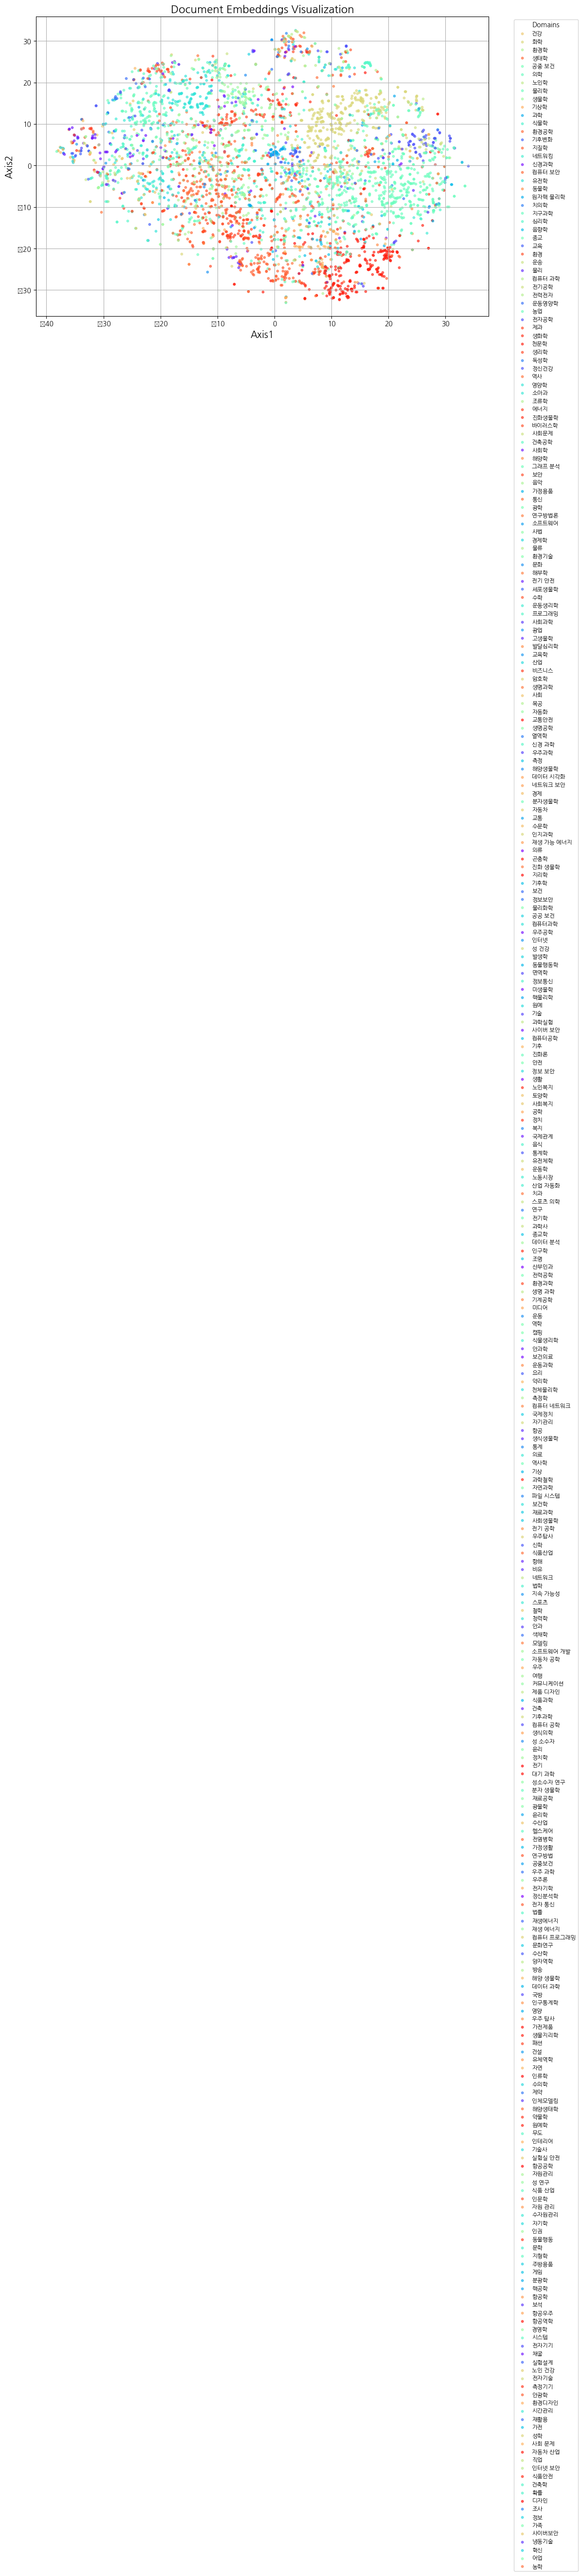

In [8]:
plt.figure(figsize=(12, 8))

domains = [doc.metadata.get("domain") for doc in documents]
unique_domains = list(set(domains))
if None in unique_domains:
    unique_domains.remove(None)

colors = cm.rainbow(np.linspace(0, 1, len(unique_domains)))
domain_to_color = {domain: color for domain, color in zip(unique_domains, colors)}

added_domains = set()
for i, doc in enumerate(documents):
    domain = doc.metadata.get("domain")
    if domain is None:
        continue
    color = domain_to_color.get(domain)

    if domain not in added_domains:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=color, label=domain, alpha=0.6, s=10)
        added_domains.add(domain)
    else:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=color, alpha=0.6, s=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Domains", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title('Document Embeddings Visualization', fontsize=16)
plt.xlabel('Axis1', fontsize=14)
plt.ylabel('Axis2', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()